### 0. Import libraries, load and clean data

In [1]:
# import custom modules
from topics_loader import TopicsLoader

# core packages
import numpy as np

# aux packages
import ipywidgets as widgets
from ipywidgets import interact

# packages for visualization
import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

sns.set()

# allow to automatically update the imported modules
%load_ext autoreload
%autoreload 2

EXPERIMENT_NAME = "-distiluse-base-multilingual-cased-v1_3015"
DATA_PATH = f"./input_data/topics{EXPERIMENT_NAME}.csv"
GROUPED_SECTIONS_FILE_PATH = "../datascraping/data/grouped_sections.json"

In [2]:
topics_loader = TopicsLoader(DATA_PATH, GROUPED_SECTIONS_FILE_PATH, embeddings_column="reduced_section_embedding", centroid_column="centroid")
topic_clusters, _, centroid_columns, emebdding_columns, embeddings_dim = (
    topics_loader.get_data()
)


### 1. Analyze data

In [3]:
# show an overview of the dataset
print(f"Number of sections: {topic_clusters.shape[0]}")
total_sections_no = topic_clusters[topic_clusters["cluster_id"] != -1].shape[0]
print(f"Number of inlier sections: {total_sections_no}")
inliers_percentage = topic_clusters[topic_clusters["cluster_id"] != -1].shape[0] / topic_clusters.shape[0] * 100
print(f"Percentage of inlier sections: {round(inliers_percentage, 2)}%")
print(f"Embedding dimensionality: {embeddings_dim}")
clusters_no = len(set(topic_clusters["cluster_id"].values)) - 1
print(f"Number of clusters: {len(set(topic_clusters["cluster_id"].values)) - 1}")

Number of sections: 11292
Number of inlier sections: 6713
Percentage of inlier sections: 59.45%
Embedding dimensionality: 15
Number of clusters: 71


##### 1.1 Check the number of points per cluster

1st percentile: 32.0
100th percentile: 634.0


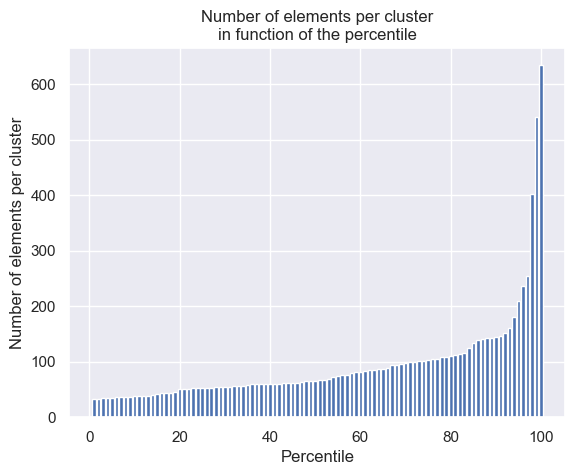

In [4]:
percentages = range(1, 101)

# get the percentiles of the number of points per cluster
elements_per_topic = (
    topic_clusters[topic_clusters["cluster_id"] != -1]
    .groupby("cluster_id")
    .count()
    .iloc[:, 1]
    .tolist()
)
percentiles = [
    np.percentile(elements_per_topic, percentile) for percentile in percentages
]

# plot percentiles
plt.bar(percentages, percentiles)
plt.title("Number of elements per cluster\nin function of the percentile")
plt.ylabel("Number of elements per cluster")
plt.xlabel("Percentile")

print(f"1st percentile: {np.percentile(elements_per_topic, 1)}")
print(f"100th percentile: {np.percentile(elements_per_topic, 100)}")


##### 1.2. Visualize the embeddings at cluster level

In [5]:
def plot_cluster_tsne(cluster_id):
    """
    It extracts the points of the associated clusters, applies t-SNE and plots them. 
    """

    embeddings = topic_clusters[topic_clusters["cluster_id"] == cluster_id][
        emebdding_columns
    ]
    embeddings_2d = TSNE(
        n_components=2, perplexity=min(elements_per_topic) - 1, metric="cosine"
    ).fit_transform(embeddings)

    plt.scatter(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1])
    plt.title(f"t-SNE visualization of embeddings for cluster {cluster_id}")


In [6]:
interact(
    plot_cluster_tsne,
    cluster_id=widgets.IntSlider(value=0, min=0, max=clusters_no - 1, step=1),
)


interactive(children=(IntSlider(value=0, description='cluster_id', max=70), Output()), _dom_classes=('widget-i…

<function __main__.plot_cluster_tsne(cluster_id)>

**Observation:** because BERTopic removed outliers the clusters are compact; however, smaller clusters seem to be composed out of multiple very small group of points

##### 1.3. Visualize all embeddings

In [7]:
def plot_tsne(embeddings, outlier_embeddings, embeddings_type, perplexity):
    """
    It applied t-SNE on the entire dataset and plots the normal and outlier data.
    """

    embeddings_2d = TSNE(
        n_components=2, perplexity=perplexity, metric="cosine"
    ).fit_transform(embeddings)

    outlier_embeddings_2d = TSNE(
        n_components=2, perplexity=perplexity, metric="cosine"
    ).fit_transform(outlier_embeddings)

    sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1])
    sns.scatterplot(x=outlier_embeddings_2d[:, 0], y=outlier_embeddings_2d[:, 1], alpha=0.3)

    plt.title(f"t-SNE visualization of embeddings at {embeddings_type} level")
    plt.legend(["embeddings", "outlier embeddings"])

    plt.show()


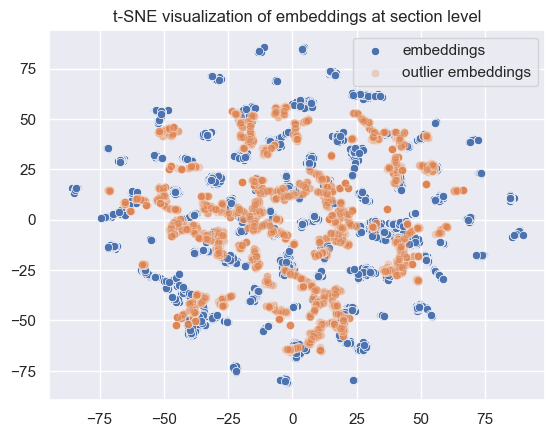

In [8]:
plot_tsne(
    topic_clusters[topic_clusters["cluster_id"] != -1][emebdding_columns],
    topic_clusters[topic_clusters["cluster_id"] == -1][emebdding_columns],
    "section",
    37,
)

